# lifelines - predictive maintenance

## Importing the libraries

In [300]:
import os
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


## Importing the dataset

In [301]:
# pyspark_df = spark.table("sd_bdc_demo.sarima_time_series_forecasting.1_service_now_survival_data")
# pyspark_df.display()
# df = pyspark_df.toPandas()

In [302]:
df = pd.read_csv("2_service_now_lifelines_updated_data/2_service_now_lifelines_updated_data.csv")


In [303]:
print(df.head())

   Asset_Number  start  stop  event  Category      usage  temperature  \
0        100080      0    25      1  Security  95.279696    49.373253   
1        100080     25    41      0  Security  96.310813    43.031546   
2        100080     41    88      1  Security  87.473264    25.520233   
3        100080     88    98      1  Security  49.422150    14.858205   
4        100080     98   145      1  Security  75.338872    48.696180   

        load  health_bar  
0  69.815955   43.497468  
1  62.939610   46.798226  
2   8.634877   64.644125  
3  28.826738   14.119441  
4  43.161360   90.799669  


In [304]:
print(df.columns)

Index(['Asset_Number', 'start', 'stop', 'event', 'Category', 'usage',
       'temperature', 'load', 'health_bar'],
      dtype='object')


In [305]:
print(df.dtypes)

Asset_Number      int64
start             int64
stop              int64
event             int64
Category         object
usage           float64
temperature     float64
load            float64
health_bar      float64
dtype: object


In [306]:
print(df.shape)

(55500, 9)


### Drop category column

In [307]:
df.drop(columns=['Category'], inplace=True)

In [308]:
print(df.shape)

(55500, 8)


## Different Data Frame For Individual assets

In [309]:
unique_assets = df['Asset_Number'].unique()
print(unique_assets)

[100080 100081 300006 300007 300008 300009 300010 300011 300012 300013
 300014 300015 300035 300036 300016 300037 300017 300018 300019 300020
 300021 300022 300038 300039 300023 300024 300025 300026 300027 300028
 300029 300030 300031 300032 300033 300034 600053 600054 600055 600056
 600057 600058 600059 600060 600061 600062 600063 600064 600065 600066
 600067 600068 600069 600070 600071 600072 600073 600074 600075 600076
 600077 600078 600079 600080 600081 600082 600083 600084 600085 600086
 600087 600088 600089 600090 600091 600092 600093 600094 600095 600096
 600097 600098 600099 600100 600101 600102 600103 600104 600105 600106
 600107 600108 600109 600110 600111 600112 600113 600114 600115 600116
 600117 600118 600119 600120 600121 600122 600123 600124 600125 600126
 600127]


In [310]:
asset_dfs = {}

for asset_id in unique_assets:
    asset_df = df[df['Asset_Number'] == asset_id]

    asset_dfs[asset_id] = asset_df

In [311]:
individual_asset = asset_dfs[100080]
print(individual_asset)

     Asset_Number  start   stop  event      usage  temperature       load  \
0          100080      0     25      1  95.279696    49.373253  69.815955   
1          100080     25     41      0  96.310813    43.031546  62.939610   
2          100080     41     88      1  87.473264    25.520233   8.634877   
3          100080     88     98      1  49.422150    14.858205  28.826738   
4          100080     98    145      1  75.338872    48.696180  43.161360   
..            ...    ...    ...    ...        ...          ...        ...   
495        100080  13500  13529      0  77.235235    37.801935  43.686996   
496        100080  13529  13574      0  11.154666     5.442308   2.871891   
497        100080  13574  13617      0  86.983858    83.032559   7.139932   
498        100080  13617  13638      1  25.759099    88.794618  59.991210   
499        100080  13638  13682      0  30.410983    84.211876  85.669728   

     health_bar  
0     43.497468  
1     46.798226  
2     64.644125  
3  

In [312]:
print(individual_asset.shape)

(500, 8)


## CoxTimeVaryingFitter on each asset dataset

In [313]:
from lifelines import CoxTimeVaryingFitter
from lifelines.utils import concordance_index

def run_ctv_pipeline(asset_df, test_size=100):
    asset_id = asset_df["Asset_Number"].iloc[0]

    # Early exit: No observed events
    if asset_df['event'].sum() == 0:
        return None, {"error": "No observed events"}

    if len(asset_df) <= test_size:
        return None, {"error": "Insufficient data for train-test split"}

    # Split
    train_df = asset_df.iloc[:-test_size].copy()
    test_df = asset_df.iloc[-test_size:].copy()

    if test_df["event"].sum() == 0:
        return None, {"error": "Test set has no events"}

    # Drop NaNs
    print(f"[{asset_id}] Before dropna - Train NaNs:\n{train_df.isnull().sum()}")
    print(f"[{asset_id}] Before dropna - Test NaNs:\n{test_df.isnull().sum()}")
    
    train_df = train_df.dropna()
    test_df = test_df.dropna()

    if train_df.empty or test_df.empty:
        return None, {"error": "Train or test set empty after dropping NaNs"}

    try:
        # Fit model
        ctv = CoxTimeVaryingFitter(penalizer=0.1)
        print(f"[{asset_id}] Dtypes:\n{train_df.dtypes}")
        print(f"[{asset_id}] Has Inf?:\n{np.isinf(train_df.select_dtypes(include=[float, int])).sum()}")
        print(f"[{asset_id}] Unique event values: {train_df['event'].unique()}")
        print(f"[{asset_id}] Sample row:\n{train_df.head(1)}")

        ctv.fit(train_df, id_col="Asset_Number", start_col="start", stop_col="stop", event_col="event")
        print(f"[{asset_id}] Cox Time-Varying Model Summary:\n{ctv.summary}")


        # Confirm all test_df columns required are present
        missing_cols = set(train_df.columns) - set(test_df.columns)
        if missing_cols:
            return None, {"error": f"Missing columns in test: {missing_cols}"}

        # Predict partial hazard
        hazard = ctv.predict_partial_hazard(test_df)
        hazard.index = test_df.index  # ✅ Align index

        print(f"[{asset_id}] Predicted Hazard:\n{hazard.head()}")
        print(f"[{asset_id}] Any NaNs in hazard?: {hazard.isnull().any()}")

        test_df["predicted_hazard"] = hazard

        # Evaluate
        c_index = concordance_index(
            test_df["stop"],
            -test_df["predicted_hazard"],
            test_df["event"]
        )



        return ctv, {
            "Concordance_Index": round(c_index, 4),
            "Train_Size": len(train_df),
            "Test_Size": len(test_df)
        }

    except Exception as e:
        import traceback
        print(f"[{asset_id}] Exception Trace:\n{traceback.format_exc()}")
        return None, {"error": str(e)}



In [314]:
results = {}

for asset_id, df_asset in asset_dfs.items():
    model, metrics = run_ctv_pipeline(df_asset)

    if model is None:
        print(f"[{asset_id}] Skipped: {metrics['error']}")
    else:
        print(f"[{asset_id}] ✅ Concordance Index: {metrics['Concordance_Index']}")
        results[asset_id] = {
            "model": model,
            "metrics": metrics
        }


[100080] Before dropna - Train NaNs:
Asset_Number    0
start           0
stop            0
event           0
usage           0
temperature     0
load            0
health_bar      0
dtype: int64
[100080] Before dropna - Test NaNs:
Asset_Number    0
start           0
stop            0
event           0
usage           0
temperature     0
load            0
health_bar      0
dtype: int64
[100080] Dtypes:
Asset_Number      int64
start             int64
stop              int64
event             int64
usage           float64
temperature     float64
load            float64
health_bar      float64
dtype: object
[100080] Has Inf?:
Asset_Number    0
start           0
stop            0
event           0
usage           0
temperature     0
load            0
health_bar      0
dtype: int64
[100080] Unique event values: [1 0]
[100080] Sample row:
   Asset_Number  start  stop  event      usage  temperature       load  \
0        100080      0    25      1  95.279696    49.373253  69.815955   

   healt

## Estimate Failure time

In [326]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def estimate_failure_time(model, asset_id, last_known_row, max_horizon=100, step=1, threshold=0.01):
    """
    Simulate future survival curve for a given asset and return estimated failure time
    where survival probability drops below `threshold`. Also plots the survival curve.
    """
    # Replicate last known covariates over simulated time intervals
    future_rows = []
    for i in range(0, max_horizon, step):
        row = last_known_row.copy()
        row["start"] = i
        row["stop"] = i + step
        row["event"] = 0  # simulate forward: no event observed
        future_rows.append(row)

    future_df = pd.DataFrame(future_rows)

    # Ensure correct column order
    cols = model.params_.index.tolist()
    future_df = future_df[["Asset_Number", "start", "stop", "event"] + cols]

    # Predict partial hazard
    partial_hazards = model.predict_partial_hazard(future_df).values.flatten()

    # Approximate cumulative hazard and survival
    cumulative_hazard = np.cumsum(partial_hazards * step)
    survival = np.exp(-cumulative_hazard)

    # Plot survival curve
    plt.figure(figsize=(8, 4))
    plt.plot(future_df["stop"], survival, label=f"Asset {asset_id}")
    plt.axhline(y=threshold, color='r', linestyle='--', label=f"{int(threshold*100)}% survival")
    plt.xlabel("Time")
    plt.ylabel("Survival Probability")
    plt.title(f"Survival Curve for Asset {asset_id}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Find time when survival drops below threshold
    failure_idx = np.where(survival < threshold)[0]
    if len(failure_idx) == 0:
        return None, survival  # survival never drops below threshold in this horizon

    failure_time = future_df.iloc[failure_idx[0]]["stop"]
    return failure_time, survival


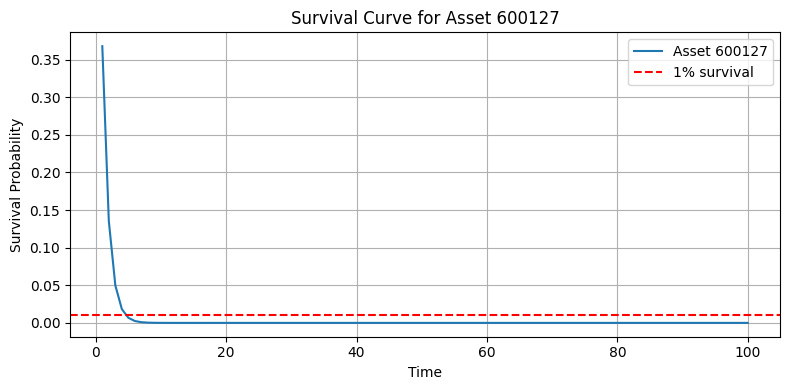

Estimated failure time (99% chance): 5.0


In [327]:
asset_id = 600127
model = results[asset_id]["model"]
last_known_row = asset_dfs[asset_id].iloc[-1].copy()

failure_time, survival_curve = estimate_failure_time(model, asset_id, last_known_row)

print(f"Estimated failure time (99% chance): {failure_time}")
